# Group 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.special import betainc

from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
test = False

In [3]:
path_data = '/home/thomas/Documents/git/medulloblastoma_cavalli_kaggle/data/in/protein_coding/'
path_metadata = path_data + 'GSE85217_Cavalli_subgroups_information_protein_coding.csv'
path_expr_mat = path_data + 'GSE85217_M_exp_763_MB_SubtypeStudy_TaylorLab_protein_coding.csv'

In [4]:
metadata = pd.read_csv(path_metadata,index_col=0)
expr_mat = pd.read_csv(path_expr_mat,index_col=0)

In [5]:
# order
expr_mat_order_vars = pd.concat([expr_mat.mean(axis=0),expr_mat.median(axis=0),expr_mat.std(axis=0)],axis=1)
expr_mat_order_vars.columns = ['mean','median','sd']
expr_mat_order_vars.sort_values(by=['mean','median','sd'],inplace=True)

expr_mat=expr_mat[expr_mat_order_vars.index.tolist()]

In [6]:
metadata['Subgroup'].unique()

array(['SHH', 'Group3', 'Group4', 'WNT'], dtype=object)

In [7]:
expr_mat_wnt = expr_mat.loc[metadata[metadata['Subgroup']=='WNT']['Study_ID'].to_list(),:]

In [8]:
# standard scaler
sc = StandardScaler()
expr_mat_wnt = sc.fit_transform(expr_mat_wnt)

In [9]:
toys_expr_mat_wnt = expr_mat_wnt[:,0:3]

In [11]:
def optim_pearson(x,y):
    # Assumes inputs are DataFrames and computation is to be performed
    # pairwise between columns. We convert to arrays and reshape so calculation
    # is performed according to normal broadcasting rules along the last axis.
    x = np.asarray(x).T[:, np.newaxis, :]
    y = np.asarray(y).T
    n = x.shape[-1]

    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(n-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)

    # Compute the two-sided p-values. See documentation of scipy.stats.pearsonr.
    ab = n/2 - 1
    x = (abs(rho) + 1)/2
    p = 2*(1-betainc(ab, ab, x))
    return rho, p

In [12]:
def chunkify_expr_mat(expr_mat,start=0,step=500):
    
    chunk_points = list(range(start,expr_mat.shape[1],step))+[expr_mat.shape[1]]
    
    for i in range(len(chunk_points)-1):
        yield chunk_points[i],chunk_points[i+1]

In [13]:
def generator_chunk_points(expr_mat,start=0,step=500):
    
    chunks = [chunk for chunk in chunkify_expr_mat(expr_mat=expr_mat,start=start,step=step)]

    for i in range(len(chunks)):
        for j in range(len(chunks)):
            yield chunks[i],chunks[j]

In [1]:
def compute_adj_mat(x,y,p_thresh,rho_thresh,chunks,k):

    rho, p = optim_pearson(x,y)

    p = np.where(p<=p_thresh,1,0)
    
    if k:
        np.fill_diagonal(p,0)
        
    rho*=p
    
    mask = np.where(abs(rho) >= rho_thresh,1,0)
    
    return rho * mask

In [13]:
#toys_expr_mat = expr_mat_wnt[:,0:10000]

In [14]:
if test:
    p_thresh=0.05
    rho_thresh=0.7
    
    adj_mat = np.zeros((toys_expr_mat.shape[1],toys_expr_mat.shape[1]))
    
    for chunk1, chunk2 in generator_chunk_points(toys_expr_mat,step=10):
    
        #test = np.array([list(chunk1),list(chunk2)])
    
        rho, p = optim_pearson(x=toys_expr_mat[:,chunk1[0]:chunk1[1]],y=toys_expr_mat[:,chunk2[0]:chunk2[1]])
    
        p = np.where(p<=p_thresh,1,0)
        
        if chunk1==chunk2:
            np.fill_diagonal(p,0)
            
        rho*=p
    
        # test 
        rho*=1.5
        
        mask = np.where(abs(rho) >= rho_thresh,1,0)
    
        adj_mat[chunk1[0]:chunk1[1],chunk2[0]:chunk2[1]] = sub_adj

In [15]:
def pool_compute_adj_mat(expr_mat,p_thresh=0.05,rho_thresh=0.7):

    adj_mat = np.zeros((expr_mat.shape[1],expr_mat.shape[1]))

    monitor = ResourceMonitor()
    monitor.start()

    results_dict = {}
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(compute_adj_mat,expr_mat[:,chunk1[0]:chunk1[1]],expr_mat[:,chunk2[0]:chunk2[1]],p_thresh,rho_thresh,np.array([chunk1,chunk2])):np.array([chunk1,chunk2]) for chunk1, chunk2 in generator_chunk_points(expr_mat,step=500)}

        for future in as_completed(futures):
            chunks = futures[future]
            try :         
                adj_mat[chunks[0][0]:chunks[0][1],chunks[1][0]:chunks[1][1]]=future.result()
            except Exception as e:
                print(f"Error in processing {chunks}: {e}")
    monitor.stop()
    return adj_mat

In [16]:
adj_mat_pearson_wnt=pool_compute_adj_mat(expr_mat=expr_mat_wnt)

RAM Usage: 41.0% | CPU Usage: 15.8%
RAM Usage: 48.1% | CPU Usage: 90.8%
RAM Usage: 49.1% | CPU Usage: 99.9%
RAM Usage: 54.0% | CPU Usage: 99.9%
RAM Usage: 51.0% | CPU Usage: 99.9%
RAM Usage: 51.6% | CPU Usage: 99.9%
RAM Usage: 54.1% | CPU Usage: 99.3%
RAM Usage: 52.7% | CPU Usage: 99.9%
RAM Usage: 57.2% | CPU Usage: 99.4%
RAM Usage: 54.0% | CPU Usage: 100.0%
RAM Usage: 59.1% | CPU Usage: 99.5%
RAM Usage: 55.3% | CPU Usage: 99.3%
RAM Usage: 61.2% | CPU Usage: 99.8%
RAM Usage: 58.3% | CPU Usage: 99.5%
RAM Usage: 60.1% | CPU Usage: 99.5%
RAM Usage: 61.3% | CPU Usage: 99.8%
RAM Usage: 58.5% | CPU Usage: 99.8%
RAM Usage: 63.4% | CPU Usage: 99.0%
RAM Usage: 59.5% | CPU Usage: 99.9%
RAM Usage: 62.0% | CPU Usage: 99.5%
RAM Usage: 67.2% | CPU Usage: 99.9%
RAM Usage: 62.4% | CPU Usage: 99.5%
RAM Usage: 65.7% | CPU Usage: 99.4%
RAM Usage: 62.3% | CPU Usage: 99.9%
RAM Usage: 67.1% | CPU Usage: 100.0%
RAM Usage: 66.2% | CPU Usage: 100.0%
RAM Usage: 65.8% | CPU Usage: 99.9%
RAM Usage: 70.2% | CPU Us

In [66]:
def adj_mat_to_df(adj_mat,expr_mat_df):

    idx = np.where(adj_mat > 0)[0]
    idx = np.unique(idx)
    
    adj_mat=adj_mat[idx,:]
    adj_mat=adj_mat[:,idx]
    
    genes = [expr_mat_df.columns[i] for i in idx]

    return pd.DataFrame(data=adj_mat, index=genes, columns=genes)

In [67]:
adj_mat_df=adj_mat_to_df(adj_mat=adj_mat_pearson_wnt,expr_mat_df=expr_mat)

In [71]:
adj_mat_df[adj_mat_df['TSPAN6']>0]['TSPAN6']

BCKDHB    0.707861
MRPL18    0.710302
SFT2D1    0.746678
Name: TSPAN6, dtype: float64

Text(0.5, 0, 'SFT2D1')

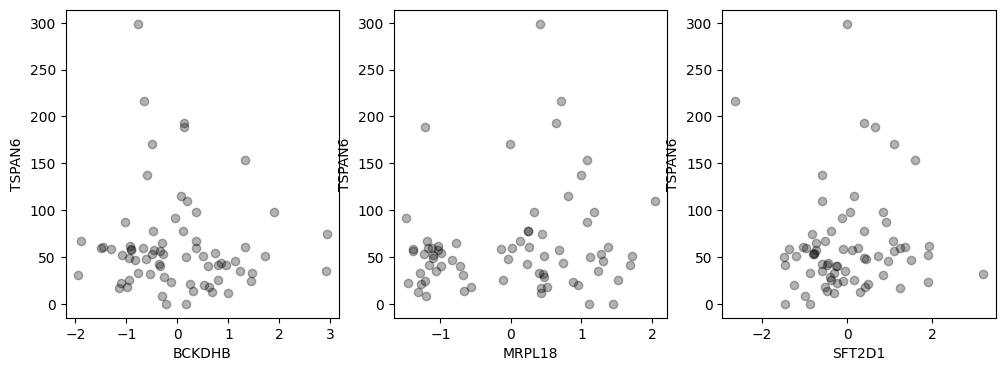

In [77]:
fig, (ax1,ax2,ax3)  = plt.subplots(1,3,figsize=(12,4))

ax1.plot(expr_mat_wnt[:,1480],expr_mat_wnt[:,0],'o',alpha=0.3,c='black')
ax1.set_ylabel('TSPAN6')
ax1.set_xlabel('BCKDHB')

ax2.plot(expr_mat_wnt[:,3692],expr_mat_wnt[:,0],'o',alpha=0.3,c='black')
ax2.set_ylabel('TSPAN6')
ax2.set_xlabel('MRPL18')

ax3.plot(expr_mat_wnt[:,15152],expr_mat_wnt[:,0],'o',alpha=0.3,c='black')
ax3.set_ylabel('TSPAN6')
ax3.set_xlabel('SFT2D1')

In [78]:
#import scipy.signal
import scipy as sp
from scipy.signal import fftconvolve

In [101]:
def fast_kde(x,y, gridsize=(300,300), extents=None, nocorrelation=True, weights=None, cov=None):

    # SETUP
    x = np.squeeze((np.asarray(x)))
    y = np.squeeze((np.asarray(y)))

    if x.size != y.size:
        raise ValueError('Input x & y arrays must be the same size!')

    n = x.size

    if weights is None:
        # Default: Weight all points equally
        weights = np.ones(n)
    else:
        weights = np.squeeze(np.asarray(weights))
        if weights.size != x.size:
            raise ValueError('Input weights must be an array of the same size'
                    ' as input x & y arrays!')

    if extents is None:
        xmin=x.min()
        xmax=x.max()
        ymin=y.min()
        ymax=y.max()
    else :
        xmin, xmax, ymin, ymax = map(float, extents)

    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin) / (gridsize[1] - 1)

    # PRELIMINARY CALCULATIONS

    # First convert x & y over to pixel coordinates
    # (Avoiding np.digitize due to excessive memory usage!)
    
    # Adjust x and y to pixel coordinates inplace
    x_pixel = np.floor((x - xmin) / dx)
    y_pixel = np.floor((y - ymin) / dy)

    # Stack the results after adjustment
    xyi = np.vstack((x_pixel, y_pixel))

    # Next, make a 2D histogram of x & y
    # Avoiding np.histogram2d due to excessive memory usage with many points
    grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

    if cov is None:
        cov = np.cov(xyi)

    print(cov)
    print(np.transpose(cov))

    if nocorrelation:
        cov[1, 0] = 0
        cov[0, 1] = 0

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    # MAKE THE GAUSSIAN KERNEL

    # First, determine how big the kernel needs to be
    std_devs = np.diag(np.sqrt(cov))
    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)
 
    # Determine the bandwidth to use for the gaussian kernel
    inv_cov = np.linalg.inv(cov * scotts_factor**2) 
 
    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
 
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))
    kernel = np.dot(inv_cov, kernel) * kernel
    kernel = np.sum(kernel, axis=0) / 2.0
    kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

    # THE KERNEL DENSITY ESTIMATE

    # Convolve the gaussian kernel with the 2D histogram, producing a gaussian
    # kernel density estimate on a regular grid
    #grid = sp.signal.convolve2d(grid, kernel, mode='same', boundary='fill').T
    grid = fftconvolve(grid, kernel, mode='same').T
    
    # Normalization factor to divide result by so that units are in the same
    # units as scipy.stats.kde.gaussian_kde's output.  
    #norm_factor = 2 * np.pi * cov * scotts_factor**2
    #norm_factor = np.linalg.det(norm_factor)
    #norm_factor = n * dx * dy * np.sqrt(norm_factor)
    
    norm_factor = n * dx * dy * (2 * np.pi) * scotts_factor**2 * np.sqrt(np.linalg.det(cov))

 
    # Normalize the result
    grid /= norm_factor

    # scale
    #grid /= np.sum(grid)

    return grid,xyi #np.flipud(grid)

    



In [102]:
toys_data_gene_1 = expr_mat_wnt[:,1]
toys_data_gene_2 = expr_mat_wnt[:,0]

In [97]:
%%time
res,xyi =fast_kde(x=toys_data_gene_1,y=toys_data_gene_2)

[[1447.88074534 -186.92463768]
 [-186.92463768 2816.16231884]]
[[1447.88074534 -186.92463768]
 [-186.92463768 2816.16231884]]
[38.05102818 53.06752603]
CPU times: user 61.3 ms, sys: 27.1 ms, total: 88.4 ms
Wall time: 45.6 ms


In [98]:
np.sum(np.where(res ==1e10, 0 , res))

0.7698324415109614

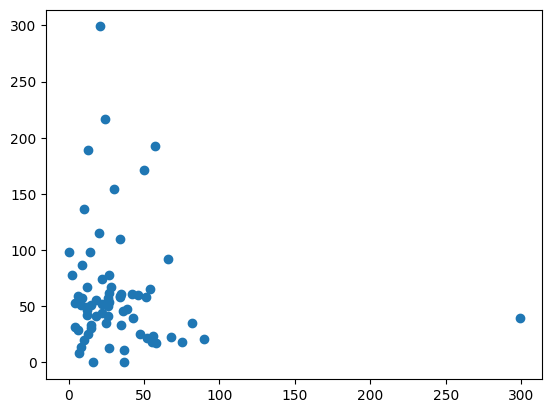

In [99]:
plt.plot(xyi[0,:],xyi[1,:],'o')

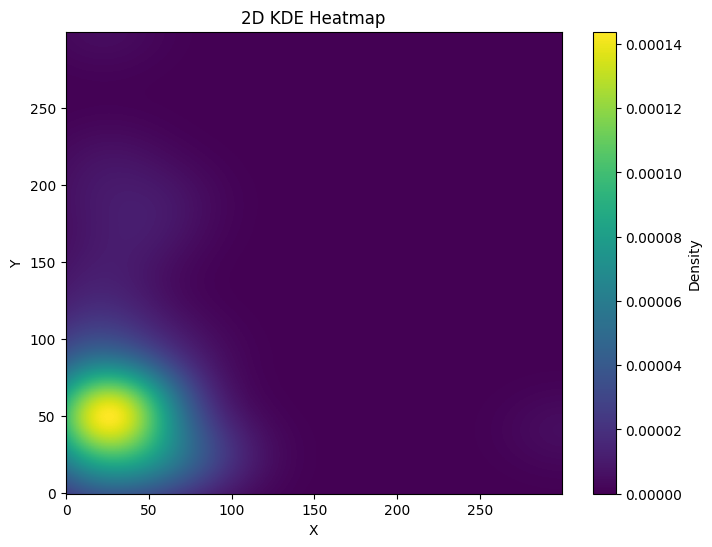

In [100]:
plt.figure(figsize=(8, 6))
plt.imshow(res, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D KDE Heatmap')
plt.show()

In [27]:
norm_exp_mat_wnt0 = expr_mat_wnt[:,0]*(np.sum(res) / np.sum(expr_mat_wnt[:,0]))
norm_exp_mat_wnt1 = expr_mat_wnt[:,1]*(np.sum(res) / np.sum(expr_mat_wnt[:,1]))

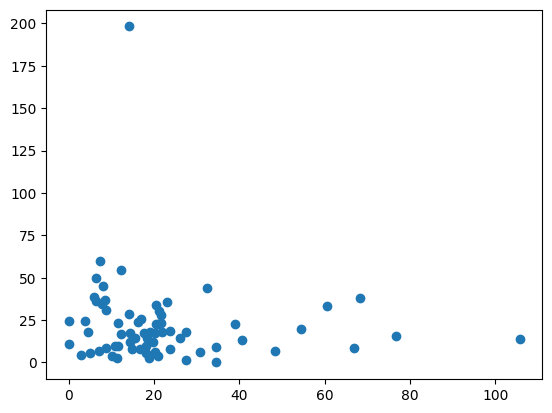

In [28]:
plt.plot(norm_exp_mat_wnt0,norm_exp_mat_wnt1,'o')

In [30]:
np.sum(expr_mat_wnt[:,1])

2306.0

In [287]:
np.sum(np.sum(res,axis=1))

1528.7026091148634

In [288]:
np.where(res > 0)

(array([  0,   0,   0, ..., 299, 299, 299]),
 array([  0,   1,   2, ..., 101, 102, 103]))

In [128]:
from KDEpy import FFTKDE

In [207]:
data = np.random.randn(2**4, 2)
data = toys_expr_mat_wnt[:,[0,1]]

In [210]:
grid_points = 200
kde = FFTKDE(kernel='gaussian', norm=np.inf)
grid, points = kde.fit(data).evaluate(100)

N = 70
data.shape

(70, 2)

In [211]:
np.sum(grid)

2989999.9999999995

In [205]:
x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
z = points.reshape(grid_points, grid_points).T

ValueError: cannot reshape array of size 10000 into shape (200,200)

TypeError: Length of x (100) must match number of columns in z (200)

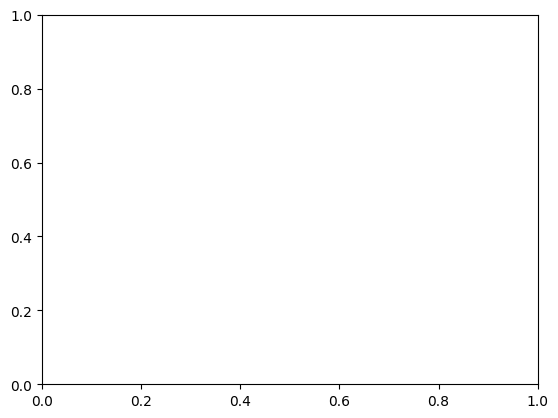

In [206]:
fig, ax = plt.subplots(1, 1)
# Plot the kernel density estimate
ax.contour(x, y, z, N, linewidths=0.8, colors='k')
ax.contourf(x, y, z, N, cmap="RdBu_r")
ax.plot(data[:, 0], data[:, 1], 'ok', ms=3)

plt.tight_layout()


array([[-5.73079023, -6.09515846],
       [-5.73079023, -6.00825454],
       [-5.73079023, -5.92135062],
       ...,
       [ 5.15117659,  4.76783127],
       [ 5.15117659,  4.85473519],
       [ 5.15117659,  4.94163911]])

In [24]:
def shannon_mi_from_kde(kde,epsilon=1e-10,normalize=True):

    p_xy = np.where(kde == 0, epsilon, kde)

    print(p_xy)

    p_x = np.sum(p_xy, axis=0)
    p_y = np.sum(p_xy, axis=1)

    mi = np.sum(p_xy * np.log2(p_xy / (p_x * p_y)))

    h_x = -np.sum(p_x * np.log2(p_x))
    h_y = -np.sum(p_y * np.log2(p_y))

    if normalize:
        mi /= np.sqrt(h_x * h_y)
    
    return mi

In [25]:
def compute_kernel(cov,scott_factors):

    # null diagonal
    std_devs = np.sum(np.sqrt(cov),axis=0)
    kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)

    # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
    xx = np.arange(kern_nx) - kern_nx / 2.0
    yy = np.arange(kern_ny) - kern_ny / 2.0
    xx, yy = np.meshgrid(xx, yy)
 
    # Then evaluate the gaussian function on the kernel grid
    kernel = np.vstack((xx.flatten(), yy.flatten()))
    
    return kernel

In [26]:
if test:
    from scipy.stats import chi2_contingency
    
    def calculate_mi_from_kde2(kde_grid):
    
        g, p, dof, expected = chi2_contingency(kde_grid, lambda_="log-likelihood")
        mi = 2 * g / kde_grid.sum()
    
        return mi

In [56]:
if test:
    def calculate_mi_from_fast_kde(kde_grid, normalized = True):
    
        p_x = np.sum(kde_grid, axis=1, keepdims=True)# Sum over y-axis to get P_x
        p_y = np.sum(kde_grid, axis=0, keepdims=True)  # Sum over x-axis to get P_y
        
        p_x = p_x[np.nonzero(p_x)]
        p_y = p_y[np.nonzero(p_y)]
        p_xy = kde_grid[np.nonzero(kde_grid)]
    
        # entropy
        h_x = -np.sum(p_x * np.log2(p_x))
        h_y = -np.sum(p_y * np.log2(p_y))
        h_xy = -np.sum(p_xy*np.log2(p_xy))
    
        mi = h_x + h_y - h_xy
    
        if normalized :
            mi /= np.sqrt(h_x * h_y)
    
        return mi

In [57]:
calculate_mi_from_fast_kde(res,normalized=False)

NameError: name 'calculate_mi_from_fast_kde' is not defined

In [75]:
def calculate_cov_std(x,y,nocorrelation=True):
    
    x = np.asarray(x).T[:, np.newaxis, :]
    y = np.asarray(y).T
    n = x.shape[-1]

    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(n-1)

    std_x = np.std(x, ddof=1, axis=-1)
    std_y = np.std(y, ddof=1, axis=-1)

    

    if nocorrelation:
        np.fill_diagonal(cov,0)

    return cov, std_x**2, std_y**2

In [82]:
def calculate_batch_mi(x,y,gridsize=(200,200),nocorrelation=True):

    xmin = x.min(axis=0)
    xmax = x.max(axis=0)
    
    ymin = y.min(axis=0)
    ymax = y.max(axis=0)

    n = x.shape[0]

    weights=np.ones(n)
    
    dx = (xmax - xmin) / (gridsize[0] - 1)
    dy = (ymax - ymin)/(gridsize[1] - 1)

    x_pix = (x - xmin) / dx
    y_pix = (y - ymin) / dy

    cov_xy, std_x, std_y = calculate_cov_std(x_pix,y_pix,nocorrelation)

    # Scaling factor for bandwidth
    scotts_factor = np.power(n, -1.0 / 6) # For 2D

    mi_batch = np.zeros((x.shape[-1],y.shape[-1]))

    #print(np.triu_indices(x.shape[-1], k=1))
    for i,j in zip(*np.triu_indices(x.shape[-1], k=1)):

        xyi = np.vstack((x_pix[:,i],y_pix[:,j]))
        grid = sp.sparse.coo_matrix((weights, xyi), shape=(gridsize)).toarray()

        cov = cov_xy[[i,j],:][:,[i,j]] 
        cov[0,0] = std_x[i]
        cov[1,1] = std_y[j]
        
        # First, determine how big the kernel needs to be
        std_devs = np.sqrt(np.diag(cov))
        kern_nx, kern_ny = np.round(scotts_factor * 2 * np.pi * std_devs)
            
        # Determine the bandwidth to use for the gaussian kernel
        inv_cov = np.linalg.inv(cov * scotts_factor**2)
    
        # x & y (pixel) coords of the kernel grid, with <x,y> = <0,0> in center
        xx = np.arange(kern_nx) - kern_nx / 2.0
        yy = np.arange(kern_ny) - kern_ny / 2.0
        xx, yy = np.meshgrid(xx, yy)
     
        # Then evaluate the gaussian function on the kernel grid
        kernel = np.vstack((xx.flatten(), yy.flatten()))
        kernel = np.dot(inv_cov, kernel) * kernel
        kernel = np.sum(kernel, axis=0) / 2.0
        kernel = np.exp(-kernel).reshape(np.int64(kern_ny), np.int64(kern_nx))

        # THE KERNEL DENSITY ESTIMATE

        # Convolve the gaussian kernel with the 2D histogram, producing a gaussian
        # kernel density estimate on a regular grid
        grid = sp.signal.convolve2d(grid, kernel, mode='same', boundary='fill').T

        # Normalization factor to divide result by so that units are in the same
        # units as scipy.stats.kde.gaussian_kde's output.  
        #norm_factor = 2 * np.pi * cov * scotts_factor**2
        #norm_factor = np.linalg.det(norm_factor)
        #norm_factor = n * dx[i] * dy[j] * np.sqrt(norm_factor)
        norm_factor = n * dx[i] * dy[j] * (2 * np.pi) * scotts_factor**2 * np.sqrt(np.linalg.det(cov))
        
        # Normalize the result
        grid /= norm_factor


        

        mi_batch[i,j] = shannon_mi_from_kde(kde = grid,epsilon=1e-10,normalize=True)

In [83]:
res = calculate_batch_mi(x=toys_expr_mat_wnt,y=toys_expr_mat_wnt)

/tmp/ipykernel_60114/3188967255.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cov[0,0] = std_x[i]


19.295511557917106
(200, 200)
[[2.46294630e-05 2.92638953e-05 3.45451684e-05 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 [2.42625680e-05 2.88404276e-05 3.40599976e-05 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 [2.38215126e-05 2.83283972e-05 3.34697646e-05 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 ...
 [1.62383198e-03 1.75777147e-03 1.89496398e-03 ... 1.94908974e-04
  1.99174433e-04 2.02214983e-04]
 [1.56042015e-03 1.68944131e-03 1.82158440e-03 ... 1.86392453e-04
  1.90553889e-04 1.93546488e-04]
 [1.49575493e-03 1.61974075e-03 1.74671778e-03 ... 1.77654233e-04
  1.81699105e-04 1.84632439e-04]]
27.337734894144784
(200, 200)
[[3.34670320e-06 4.05576710e-06 4.89386481e-06 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 [3.30262826e-06 4.00353331e-06 4.83226064e-06 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 [3.24830425e-06 3.93884054e-06 4.75557733e-06 ... 1.00000000e-10
  1.00000000e-10 1.00000000e-10]
 ...
 [5.55479837e-04 5.88874569e-04 6.2274

In [552]:
toys_expr_mat_wnt.shape

(70, 10)

In [288]:
toys_expr_mat_wnt

array([[ 32.,   8.,  34., ..., 160.,  40.,  52.],
       [ 21.,   2.,  63., ..., 191.,  43.,  40.],
       [ 20.,  10.,  79., ...,  61.,  94., 103.],
       ...,
       [ 16.,  37., 100., ..., 100., 105.,  55.],
       [ 22.,  23.,  37., ...,  88.,   0.,  70.],
       [ 36.,  18.,  93., ..., 163.,  52., 152.]])

In [279]:
#kde = FFTKDE(kernel='gaussian', norm=np.inf).fit(expr_mat_wnt[:,[0,1480]])

#kde = FFTKDE(kernel='gaussian', norm=np.inf).fit(expr_mat_wnt[:,[1480]])
#entropy(kde.evaluate(grid_points))

In [290]:
grid

array([-2.44305081, -2.38449381, -2.3259368 , -2.2673798 , -2.20882279,
       -2.15026579, -2.09170878, -2.03315178, -1.97459477, -1.91603777,
       -1.85748076, -1.79892376, -1.74036675, -1.68180974, -1.62325274,
       -1.56469573, -1.50613873, -1.44758172, -1.38902472, -1.33046771,
       -1.27191071, -1.2133537 , -1.1547967 , -1.09623969, -1.03768269,
       -0.97912568, -0.92056868, -0.86201167, -0.80345467, -0.74489766,
       -0.68634065, -0.62778365, -0.56922664, -0.51066964, -0.45211263,
       -0.39355563, -0.33499862, -0.27644162, -0.21788461, -0.15932761,
       -0.1007706 , -0.0422136 ,  0.01634341,  0.07490041,  0.13345742,
        0.19201442,  0.25057143,  0.30912844,  0.36768544,  0.42624245,
        0.48479945,  0.54335646,  0.60191346,  0.66047047,  0.71902747,
        0.77758448,  0.83614148,  0.89469849,  0.95325549,  1.0118125 ,
        1.0703695 ,  1.12892651,  1.18748352,  1.24604052,  1.30459753,
        1.36315453,  1.42171154,  1.48026854,  1.53882555,  1.59

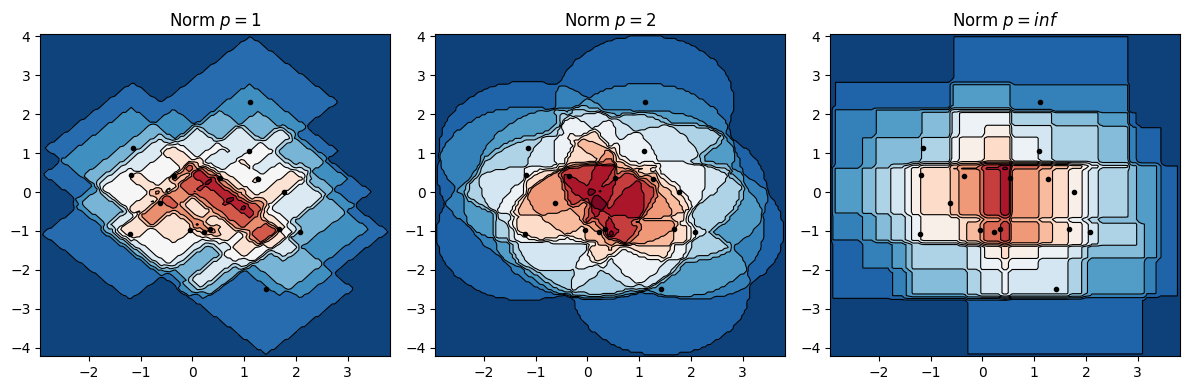

In [277]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt

# Create 2D data of shape (obs, dims)
data = np.random.randn(2**4, 2)

grid_points = 2**7  # Grid points in each dimension
N = 16  # Number of contours

# Initialize the figure
fig = plt.figure(figsize=(12, 4))

for plt_num, norm in enumerate([1, 2, np.inf], 1):
    ax = fig.add_subplot(1, 3, plt_num)
    ax.set_title(f'Norm $p={norm}$')

    # Compute the kernel density estimate
    kde = FFTKDE(kernel='box', norm=norm)
    grid, points = kde.fit(data).evaluate(grid_points)

    # The grid is of shape (obs, dims), points are of shape (obs, 1)
    x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
    z = points.reshape(grid_points, grid_points).T

    # Plot the kernel density estimate
    ax.contour(x, y, z, N, linewidths=0.8, colors='k')
    ax.contourf(x, y, z, N, cmap="RdBu_r")
    ax.plot(data[:, 0], data[:, 1], 'ok', ms=3)

plt.tight_layout()
plt.show()


In [284]:
grid_points
2**4

16

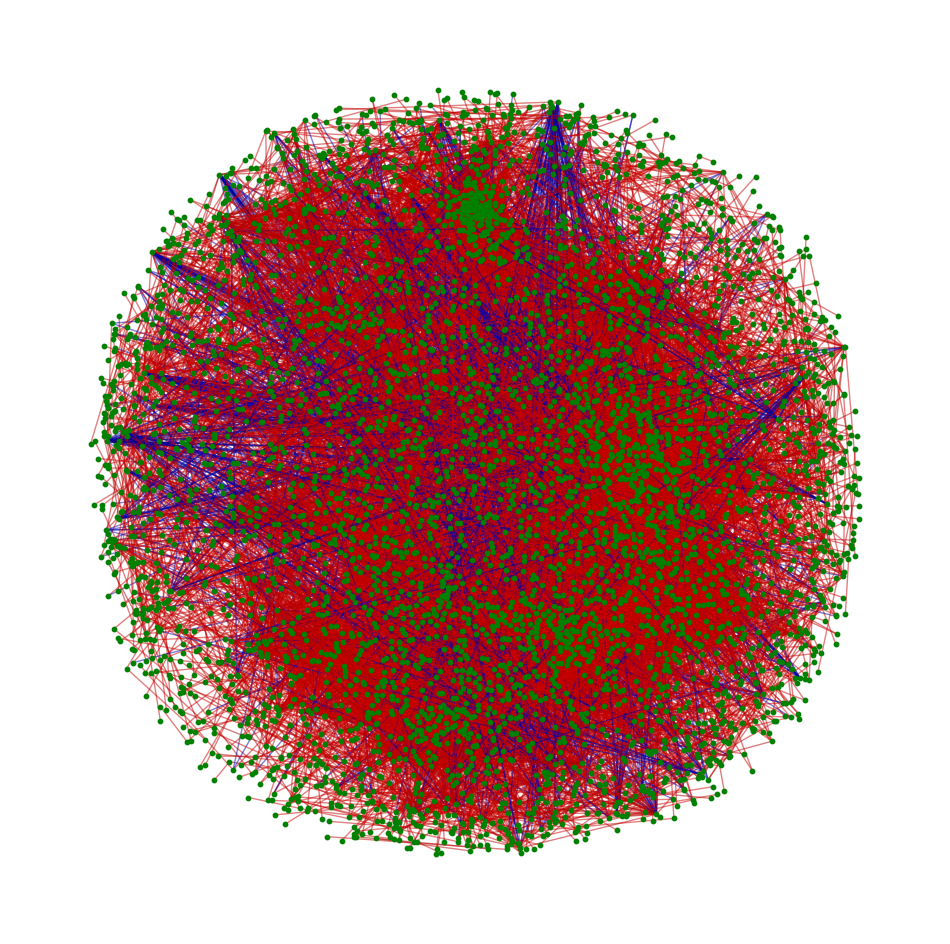

In [140]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

graph_wnt = nx.Graph()
genes = adj_mat_df.columns.tolist()
graph_wnt.add_nodes_from(genes)

adj_mat_edge_idx = np.where(adj_mat_df!=0)


for i,j in zip(*adj_mat_edge_idx):
    node1=genes[i]
    node2=genes[j]
    if not graph_wnt.has_edge(node1,node2):
        graph_wnt.add_edge(node1,node2,weight=adj_mat_df.loc[node1,node2])

weights = [graph_wnt[u][v]['weight'] for u, v in graph_wnt.edges()]
    
cmap = cm.seismic  # bleu -> blanc -> rouge
norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cmap(norm(weight)) for weight in weights]
    
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph_wnt, seed=42, k=0.15)
    
nx.draw_networkx_nodes(graph_wnt, pos, node_size=10, node_color='green')
    
nx.draw_networkx_edges(graph_wnt, pos, edge_color=edge_colors, alpha=0.5)
    
plt.axis('off')
plt.show()

In [165]:
expr_mat_wnt[:,0:100]

array([[-0.2474053 , -0.56469084, -0.62686693, ...,  1.87796543,
        -0.6862804 , -0.6929952 ],
       [-0.56761695, -0.77662084,  0.28654135, ...,  2.60642696,
        -0.60367479, -1.0121425 ],
       [-0.59347401, -0.47185138,  0.82231947, ..., -0.38618093,
         0.56857687,  0.68791422],
       ...,
       [-0.71508732,  0.60070066,  1.49193608, ...,  0.51744164,
         0.84133987, -0.60547668],
       [-0.54644265,  0.04707845, -0.54619101, ...,  0.22702775,
        -1.59580385, -0.20914446],
       [-0.14777112, -0.1540229 ,  1.28162252, ...,  1.94866037,
        -0.38853889,  1.99617408]])

In [238]:
def joint_entropies(x,y,nbins=None):

    n_vars = x.shape[1]
    
    n_samples = x.shape[0]
    
    if nbins is None:
        binwidth = 0.1 # (n_samples**(-1/3))*3.5
        print(binwidth)
        range_x = x.max(axis=0)-x.min(axis=0)
        range_y = y.max(axis=0)-y.min(axis=0)
        range_i = np.concatenate([range_x,range_y],axis=0)
        nbins = int(range_i.min() / (n_samples**(-1/3))*3.5)

    histograms2d = np.zeros((n_vars, n_vars, nbins, nbins))
    idx = np.tril_indices(n_vars)

    for i,j in zip(*idx):
        hist2d, _, _ = np.histogram2d(x[:,i],y[:,j], bins=nbins)
        if i != j:
            histograms2d[j, i] = hist2d.T
            
    probs = histograms2d / n_samples + 1e-10
    joint_entropies = -(probs * np.log2(probs)).sum(axis=(2, 3))

    return joint_entropies

def mutual_info_matrix(x,y,nbins=None, normalized=None):
    n_vars = x.shape[-1]

    j_entropies = joint_entropies(x,y,nbins)

    entropies = j_entropies.diagonal()
    sum_entropies = entropies[:, None] + entropies[None, :]
    mi_matrix = sum_entropies - j_entropies

    if normalized:
        with np.errstate(divide='ignore', invalid='ignore'):
            mi_matrix = np.nan_to_num((mi_matrix * 2) / sum_entropies)

    return mi_matrix

In [242]:
#joint_entropies(x=expr_mat_wnt[:,0:100],y=expr_mat_wnt[:,0:100],nbins=None)

In [241]:
#mutual_info_matrix(x=expr_mat_wnt[:,0:10],y=expr_mat_wnt[:,0:10],nbins=None,normalized=True)

In [243]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

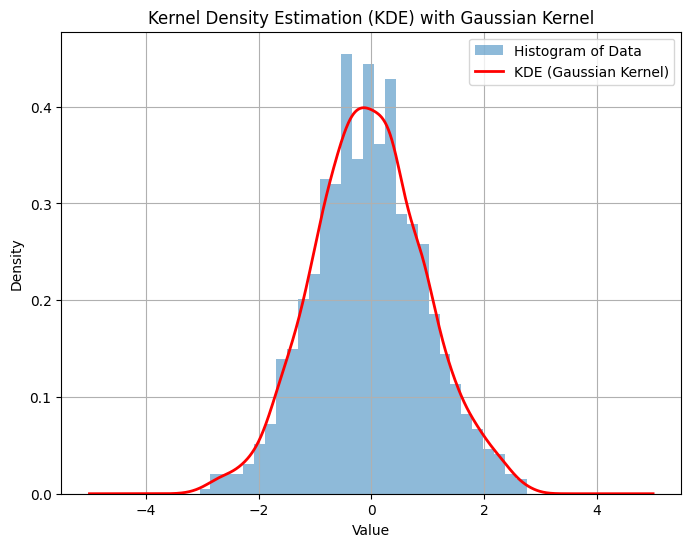

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Step 1: Generate some sample data
np.random.seed(0)
data = np.random.normal(0, 1, 1000)  # 1000 data points from a normal distribution (mean=0, std=1)

# Step 2: Calculate the bandwidth using Silverman's rule of thumb
def silverman_bandwidth(data):
    """Compute Silverman's bandwidth for univariate data."""
    n = len(data)
    std_dev = np.std(data, ddof=1)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * min(std_dev, iqr / 1.34) * n ** (-1/5)
    return bandwidth

# Step 3: Apply Gaussian KDE
bandwidth = silverman_bandwidth(data)  # Compute bandwidth using Silverman's rule
kde = gaussian_kde(data, bw_method=bandwidth)  # Fit the KDE with the calculated bandwidth

# Step 4: Evaluate the KDE on a range of values (x-axis)
x = np.linspace(-5, 5, 1000)  # Generate a range of values
density = kde(x)  # Evaluate the density estimate at these points

# Step 5: Plot the results
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.5, label="Histogram of Data")
plt.plot(x, density, label="KDE (Gaussian Kernel)", color='red', lw=2)
plt.title("Kernel Density Estimation (KDE) with Gaussian Kernel")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

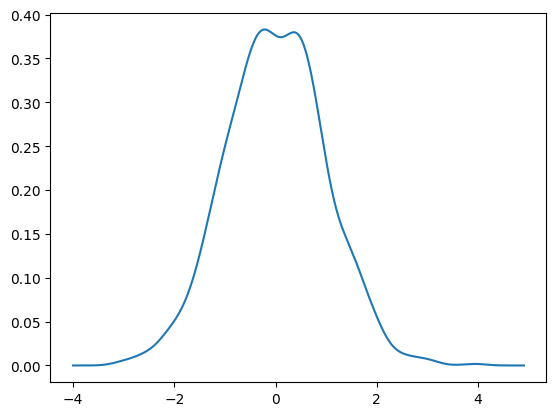

In [252]:
from KDEpy import FFTKDE
import numpy as np

def silverman_bandwidth(data):
    """Compute Silverman's bandwidth for univariate data."""
    n = len(data)
    std_dev = np.std(data, ddof=1)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * min(std_dev, iqr / 1.34) * n ** (-1/5)
    return bandwidth

# Generate example data
data = np.random.normal(0, 1, 1000)

# Calculate bandwidth (using Silverman's rule)
bandwidth = silverman_bandwidth(data)

# Use FFTKDE with the computed bandwidth
kde = FFTKDE(bw=bandwidth).fit(data)
grid, density = kde.evaluate()

# Optionally plot or inspect the results
import matplotlib.pyplot as plt
plt.plot(grid, density)
plt.show()

In [267]:
import numpy as np
from KDEpy import FFTKDE
from scipy.integrate import simps

def kde_pdf(data, bandwidth=0.1, grid_size=100):
    # Kernel Density Estimation
    kde = FFTKDE(bw=bandwidth)
    grid, pdf = kde.fit(data).evaluate()
    return grid, pdf / np.sum(pdf)

def mutual_information_kde(gene1_values, gene2_values, bandwidth=0.1):
    # 1. Estimate the marginal PDFs for each gene
    grid_x, pdf_x = kde_pdf(gene1_values, bandwidth)
    grid_y, pdf_y = kde_pdf(gene2_values, bandwidth)

    # 2. Estimate the joint PDF for (gene1, gene2) pair
    joint_data = np.vstack([gene1_values, gene2_values]).T
    kde_joint = FFTKDE(bw=bandwidth)
    grid_joint, pdf_joint = kde_joint.fit(joint_data).evaluate()
    pdf_joint = pdf_joint / np.sum(pdf_joint)

    # 3. Calculate mutual information
    mi = 0
    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_y):
            p_xy = pdf_joint[i, j]
            p_x = pdf_x[i]
            p_y = pdf_y[j]
            if p_xy > 0:  # Avoid log(0)
                mi += p_xy * np.log(p_xy / (p_x * p_y + 1e-10) + 1e-10)
    
    # Multiply by grid spacing to approximate integral
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    mi *= dx * dy
    return mi

# Sample gene expression data (e.g., for 5 samples)
gene1_values = np.array([5, 10, 15, 10, 5])  # Expression values of Gene 1
gene2_values = np.array([2, 3, 5, 3, 2])     # Expression values of Gene 2

# Calculate mutual information between Gene 1 and Gene 2
mi_value = mutual_information_kde(gene1_values, gene2_values, bandwidth=0.1)
print("Mutual Information between Gene 1 and Gene 2:", mi_value)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [262]:
adj_mat_edge_idx

(array([   0,    0,    0, ..., 4651, 4651, 4652]),
 array([  72,  508,  740, ..., 4306, 4523, 4468]))

In [119]:
len(adj_mat_df.columns)

4653

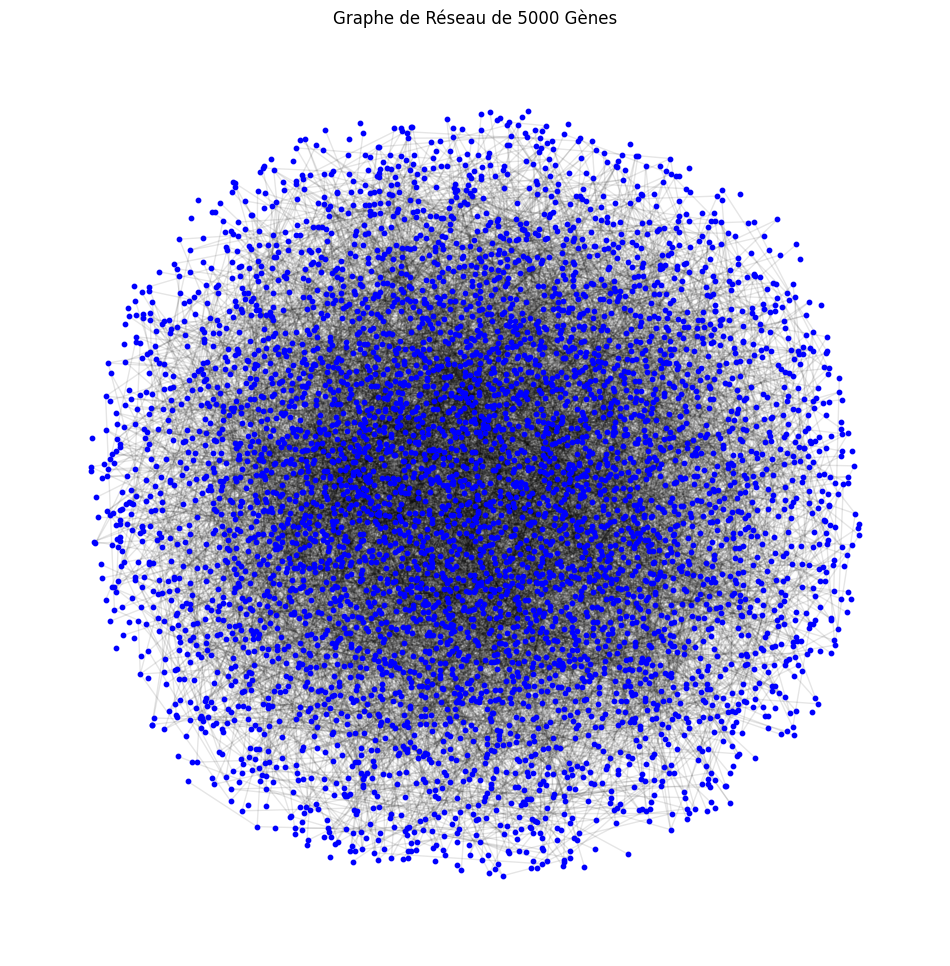

In [117]:
import networkx as nx
import matplotlib.pyplot as plt
import random

#1. Créer un graphe NetworkX
G = nx.Graph()

# 2. Ajouter environ 5000 gènes comme nœuds
num_genes = 5000
genes = [f"Gene_{i}" for i in range(num_genes)]
G.add_nodes_from(genes)

# 3. Ajouter des arêtes entre les gènes (par exemple, avec des connexions aléatoires)
# Vous pouvez aussi définir une règle spécifique ici pour les connexions
num_edges = 10000  # Choisissez un nombre d'arêtes pour relier certains gènes

for _ in range(num_edges):
    # Sélectionner deux nœuds (gènes) aléatoires et les connecter
    node1 = random.choice(genes)
    node2 = random.choice(genes)
    if node1 != node2:  # éviter les boucles
        G.add_edge(node1, node2)

# 4. Visualisation du réseau
# Note : Avec 5000 nœuds, la visualisation sera très dense et difficile à lire

plt.figure(figsize=(12, 12))
# Utilisation de layout spring pour un effet visuel, mais ça peut être lent
pos = nx.spring_layout(G, seed=42, k=0.15)  # k peut ajuster la densité des nœuds
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title("Graphe de Réseau de 5000 Gènes")
plt.axis('off')
plt.show()

In [18]:
if test:
    p_thresh=0.05
    rho_thresh=0.7
    
    adj_mat = np.zeros((expr_mat.shape[1],expr_mat.shape[1]))
    
    monitor = ResourceMonitor()
    monitor.start()
    
    results_dict = {}
    with ProcessPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(compute_adj_mat,expr_mat[:,chunk1[0]:chunk1[1]],expr_mat[:,chunk2[0]:chunk2[1]],p_thresh,rho_thresh,np.array([chunk1,chunk2])):np.array([chunk1,chunk2]) for chunk1, chunk2 in generator_chunk_points(expr_mat,step=500)}
    
        for future in as_completed(futures):
            chunks = futures[future]
            try :         
                adj_mat[chunks[0][0]:chunks[0][1],chunks[1][0]:chunks[1][1]]=future.result()
            except Exception as e:
                print(f"Error in processing {chunks}: {e}")
    monitor.stop()

In [276]:
from KDEpy import FFTKDE

# Create 2D data of shape (obs, dims)
data = np.random.randn(2**4, 2)

grid_points = 2**7  # Grid points in each dimension
N = 16  # Number of contours

for plt_num, norm in enumerate([1, 2, np.inf], 1):

    ax = fig.add_subplot(1, 3, plt_num)
    ax.set_title(f'Norm $p={norm}$')

    # Compute the kernel density estimate
    kde = FFTKDE(kernel='box', norm=norm)
    grid, points = kde.fit(data).evaluate(grid_points)

    # The grid is of shape (obs, dims), points are of shape (obs, 1)
    x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
    z = points.reshape(grid_points, grid_points).T

    # Plot the kernel density estimate
    ax.contour(x, y, z, N, linewidths=0.8, colors='k')
    ax.contourf(x, y, z, N, cmap="RdBu_r")
    ax.plot(data[:, 0], data[:, 1], 'ok', ms=3)

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [279]:
data.shape

(16, 2)

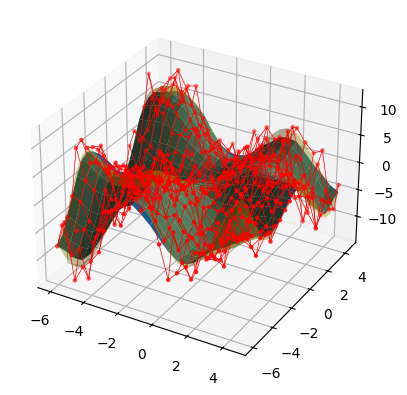

CPU times: user 454 ms, sys: 347 ms, total: 801 ms
Wall time: 253 ms


In [220]:
%%time
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#import sgolay2

np.random.seed(12345)

x, y = np.mgrid[-6:5:.5, -6:5:.5]
z = y * np.sin(x) + x * np.cos(y)
zn = z + np.random.randn(*x.shape) * 2.

zs = SGolayFilter2(window_size=9, poly_order=3)(zn)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x, y, zn, linewidths=0.5, color='r')
ax.scatter(x, y, zn, s=5, c='r')

ax.plot_surface(x, y, zs, linewidth=0)
ax.plot_surface(x, y, z, color='y', linewidth=0, alpha=0.4)

plt.show()

In [218]:
z.shape

(22, 22)

In [215]:
# -*- coding: utf-8 -*-

"""
Two-dimensional Savitzky-Golay filter

"""

import collections
import typing as t

import numpy as np
import numpy.linalg as la

import scipy.ndimage as ndim


Param2 = collections.namedtuple('Param2', ('row', 'column'))
Polynom2 = collections.namedtuple('Polynom2', ('row_pows', 'column_pows', 'num_coeffs'))

_Param2Type = t.Union[Param2, t.Tuple[int, int]]
_ParamType = t.Union[int, _Param2Type]

_DIM = 2


class SGolayKernel2:
    """Computes two-dimensional kernel (weights) for Savitzky-Golay filter
    """

    def __init__(self, window_size: _Param2Type, poly_order: _Param2Type):
        self._window_size = Param2(*window_size)
        self._poly_order = Param2(*poly_order)

        self._kernel = None  # type: np.ndarray
        self.computed = False

    def __call__(self):
        self.compute()

    def compute(self):
        if self.computed:
            return

        polynom = self._make_polynom(self._poly_order)
        basis_matrix = self._make_basis_matrix(self._window_size, polynom)

        self._kernel = self._compute_kernel(self._window_size, basis_matrix)

        self.computed = True

    @property
    def kernel(self) -> np.ndarray:
        """Returns 2D Savitzky-Golay kernel
        """
        self.compute()
        return self._kernel

    @staticmethod
    def _make_polynom(poly_order: Param2) -> Polynom2:
        """
        Creates 2-D polynom model (for example poly33):
            p = a00 + a10x + a01y + a20x^2 + a11xy + a02y^2 + a30x^3 + a21x^2y \
                + a12xy^2 + a03y^3
        """
        row_pows = []
        column_pows = []
        num_coeffs = 0

        for row in range(poly_order.row + 1):
            for column in range(poly_order.column + 1):
                if (row + column) > max(*poly_order):
                    continue

                row_pows.append(row)
                column_pows.append(column)

                num_coeffs += 1

        return Polynom2(row_pows, column_pows, num_coeffs)

    @staticmethod
    def _make_basis_matrix(window_size: Param2, poly: Polynom2) -> np.ndarray:
        """Creates basis polynomial matrix
        """
        basis_rows = window_size.row * window_size.column
        basis_columns = poly.num_coeffs

        basis_matrix = np.zeros((basis_rows, basis_columns))

        radius_row = (window_size.row - 1) // 2
        radius_column = (window_size.column - 1) // 2

        row_pows = np.array(poly.row_pows)
        column_pows = np.array(poly.column_pows)

        k = 0

        for row in range(-radius_row, radius_row + 1):
            for column in range(-radius_column, radius_column + 1):
                basis_matrix[k, :] = column ** column_pows * row ** row_pows
                k += 1

        return basis_matrix

    @staticmethod
    def _compute_kernel(window_size: Param2,
                        basis_matrix: np.ndarray) -> np.ndarray:
        """Computes filter 2D kernel via solving least squares problem
        """
        q, _ = la.qr(basis_matrix)

        iq = (window_size.row * window_size.column - 1) // 2
        kernel = q @ np.array(q[iq, :], ndmin=2).T
        kernel = np.fliplr(kernel.reshape(*window_size, order='F'))

        return kernel


class SGolayFilter2:
    """Two-dimensional Savitzky-Golay filter
    """

    def __init__(self, window_size: _ParamType, poly_order: _ParamType):
        self._window_size = self._canonize_param(
            'window_size', window_size, self._validate_window_size)
        self._poly_order = self._canonize_param(
            'poly_order', poly_order, self._validate_poly_order)

        self._kernel = SGolayKernel2(self._window_size, self._poly_order)

    def __call__(self, data: np.ndarray,
                 mode: str = 'reflect', cval: float = 0.0):
        return self._filtrate(data, mode=mode, cval=cval)

    @property
    def window_size(self) -> Param2:
        return self._window_size

    @property
    def poly_order(self) -> Param2:
        return self._poly_order

    @property
    def kernel(self) -> SGolayKernel2:
        """Returns filter 2D kernel
        """
        return self._kernel

    @staticmethod
    def _canonize_param(name, value: _ParamType, validator) -> Param2:
        err = TypeError(
            'The parameter "{}" must be int scalar or Tuple[int, int]'.format(
                name))

        if isinstance(value, int):
            value = (value, value)

        if not isinstance(value, (list, tuple)):
            raise err
        if len(value) != _DIM:
            raise err
        if not all(isinstance(v, int) for v in value):
            raise err

        validator(value)

        return Param2(*value)

    @staticmethod
    def _validate_window_size(value):
        if not all(v >= 3 and bool(v % 2) for v in value):
            raise ValueError(
                'Window size values must be odd and >= 3 (Given: {})'.format(
                    value))

    @staticmethod
    def _validate_poly_order(value):
        if not all(v >= 1 for v in value):
            raise ValueError(
                'Polynom order values must be >= 1 (Given: {})'.format(value))

    def _filtrate(self, data: np.ndarray, *args, **kwargs):
        self._kernel.compute()
        return ndim.correlate(data, self._kernel.kernel, *args, **kwargs)

In [69]:
%%time
from numba import njit
import numpy as np

@njit
def compute_sum(arr):
    result = 0.0
    for x in arr:
        result += np.sin(x) ** 2
    return result

# Usage
arr = np.random.rand(1000000)
print(compute_sum(arr))

272763.3726915292
CPU times: user 274 ms, sys: 2.94 ms, total: 277 ms
Wall time: 274 ms
